## This is a FSI problem of 2 passive plates linked with spring and damper, oscillating in fluid

In [ ]:
using Revise
using Roots
using BSON: @save, @load

using Pkg
Pkg.activate("..")
using FSI

In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

In [3]:
filename = "2dLink";

## <span style="color:blue"> Set up rigid body with Dyn3d

#### Include any joint-body setup script from Dyn3d

In [4]:
# problem dimension
ndim = 2
# numerical params
tf = 2
dt = 1e-3
scheme = "Liska"
st = 3
tol = 1e-4
num_params = NumParams(tf, dt, scheme, st, tol)
# gravity
gravity = [0., 0., 0.]

# set up system config info
config_system = ConfigSystem(ndim, gravity, num_params)

# set up bodys
nbody = 2
config_body = ConfigBody(nbody, 4,
    [0. 0.; 1. 0.; 1. 1.0/nbody; 0. 1.0/nbody], 1.0)
config_bodys = fill(config_body, nbody)

# set up joints
njoint = nbody
stiff = 0.075
damp = 0.0016
config_joints = Vector{ConfigJoint}(undef,njoint)
gap = 0.025

dof = Dof(3, "passive", stiff, damp, Motions())

config_joints[1] = ConfigJoint(njoint, "revolute",
    [0.,0.,0.0,0.5,1.5,0.], zeros(Float64,6), 0, [dof], [0.0])

for i = 2:njoint
    config_joints[i] = ConfigJoint(njoint, "revolute", [0., 0., 0.0, 1.0/njoint+gap, 0., 0.],
        [0., 0., 0., -gap, 0., 0.], i-1, [dof], [π/6])
end

#### Build joint-body chain

In [5]:
bs, js, bsys = BuildChain(config_bodys, config_joints, config_system)
bd = BodyDyn(bs, js, bsys)

This is a 2 body-joint system, system is fixed in space

#### Initialize rigid body system state to complete body-joint information

In [6]:
bd, soln₀ = InitSystem!(bd);

#### Initialize u and λ container

In [7]:
qJ = soln₀.qJ
v = soln₀.v
λ_dim = bd.sys.ncdof_HERK
λ = zeros(Float64,λ_dim);

#### Get body verts for plotting

In [8]:
@get bd (bs, js, sys)
bs, js, sys = UpdatePosition!(bs, js, sys, soln₀.qJ)
vs₀ = VertsHistory(sys.nbody, bs);

#### Plot body only

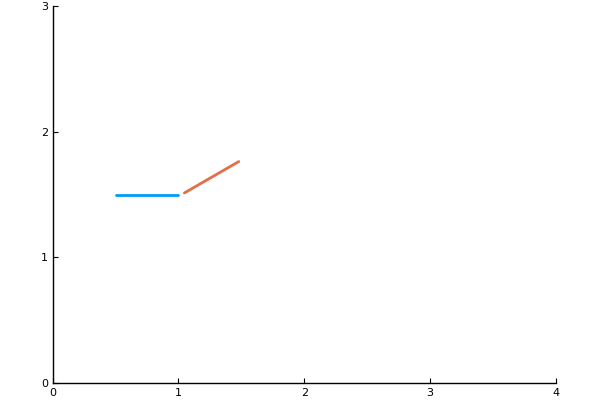

In [9]:
p = plot()
for i = 1:sys.nbody
    plot!(p,vs₀[i,2:3,1], vs₀[i,2:3,2],linewidth=2)
end
plot!(xlims=(0,4), ylims=(0,3), ratio=1, legend=false)

## <span style="color:blue"> Set up fluid with Whirl </span>

#### Set the flow parameters

In [10]:
Re = 200 # Reynolds number
U = 1.0 # Free stream velocity
U∞ = (U, 0.0)

(1.0, 0.0)

#### Set the domain grid

In [11]:
nx = 202; ny = 152;
Ly = 3.0;
Δx = Ly/(ny-2);
Δt = min(0.5*Δx,0.5*Δx^2*Re)
w₀ = Nodes(Dual,(nx,ny))
xg, yg = coordinates(w₀,dx=Δx)

(-0.01:0.02:4.01, -0.01:0.02:3.0100000000000002)

#### Set up fluid initial conditions

In [12]:
w₀ .= 0.0;
w = deepcopy(w₀);

## <span style="color:blue"> Create fluid-body interface </span>

#### Body in fluid plane

In [13]:
plane = [1,2];

#### Genrate body grid points and get linear velocity on them

In [14]:
bgs = GenerateBodyGrid(bd; np=DetermineNP(nbody, Δx, fine=1))
bgs = CutOut2d(bd,bgs);

#### Get body points initial coordinates for fluids

In [15]:
bgs = AcquireBodyGridKinematics(bd,bgs);

#### Set up body grid points and force container in fluid

In [16]:
X̃ = BodyGridToVectorData(bgs,"coord";plane=plane)
f = VectorData(X̃);

#### Create fluidstruct structure

In [17]:
tf = 2000Δt
T = Δt:Δt:tf
fsys = FluidStruct((nx,ny),Re,Δx,Δt,U∞ = U∞, X̃ = X̃, rk=RK31)
N = length(X̃)÷2

52

## <span style="color:blue"> Create ifherk object </span>

In [18]:
@time ifherk_coupled = IFHERK_coupled(fsys.Δt,bd,bgs,(w₀,qJ,v,f,λ),
                ((t,u) -> Systems.plan_intfact(t,u,fsys), B₁ᵀ, B₂),
                (M⁻¹, G₁ᵀ, G₂, UpP, UpV),
                ((bd,bgs,f) -> T₁ᵀ(bd,bgs,f,fsys.Δx;plane=plane),
                 (bd,bgs,u) -> T₂(bd,bgs,u;plane=plane),
                 (bd,bgs) -> getX̃(bd,bgs;plane=plane)),
                ((w,t) -> FSI.r₁(w,t,fsys), F, w -> U_inf(w,fsys), gti),
                fsys, tol=1e-3,rk=TimeMarching.RK31)

  7.881404 seconds (22.15 M allocations: 1.565 GiB, 6.99% gc time)


Stage-3+ IF-HERK integrator with
   Time step size 0.01


In [19]:
fx = Float64[]
fy = Float64[]
t = 0.0
thist = []
whist = []
bdhist = BodyDyn[];

## <span style="color:blue"> TimeMarching! </span>

In [20]:
@time for ti in T
    
    @time global t, (w, f), (qJ, v, λ), bd = ifherk_coupled(t, w, qJ, v, bd,fsys)
    
    push!(thist,t-Δt)
    push!(fx,sum(f.u)*Δx^2)
    push!(fy,sum(f.v)*Δx^2)
    push!(whist,deepcopy(w))
    push!(bdhist,deepcopy(bd))
    println("next time unit is $(round(t,digits=3))")
    
    if mod(ti/Δt,200) == 1  
        @save filename*".bson" bd bdhist xg yg whist thist fx fy Δt w qJ v
        println("data saved at time ", ti)
    end
end

  4.412936 seconds (8.44 M allocations: 951.117 MiB, 4.29% gc time)
next time unit is 0.01
data saved at time 0.01
  2.574550 seconds (4.89 M allocations: 784.423 MiB, 4.40% gc time)
next time unit is 0.02
  2.524693 seconds (4.89 M allocations: 784.423 MiB, 4.25% gc time)
next time unit is 0.03
  2.608877 seconds (4.89 M allocations: 784.423 MiB, 4.31% gc time)
next time unit is 0.04
  2.515119 seconds (4.89 M allocations: 784.423 MiB, 4.12% gc time)
next time unit is 0.05
  2.613242 seconds (4.89 M allocations: 784.423 MiB, 4.04% gc time)
next time unit is 0.06
  2.756108 seconds (4.89 M allocations: 784.459 MiB, 7.15% gc time)
next time unit is 0.07
  2.555506 seconds (4.89 M allocations: 784.423 MiB, 3.55% gc time)
next time unit is 0.08
  2.660273 seconds (4.89 M allocations: 784.423 MiB, 3.68% gc time)
next time unit is 0.09
  2.657848 seconds (4.89 M allocations: 784.423 MiB, 3.34% gc time)
next time unit is 0.1
  2.471470 seconds (4.89 M allocations: 784.423 MiB, 3.78% gc time)

  2.921514 seconds (4.89 M allocations: 784.423 MiB, 3.68% gc time)
next time unit is 0.91
  2.827655 seconds (4.89 M allocations: 784.423 MiB, 3.67% gc time)
next time unit is 0.92
  3.153921 seconds (4.89 M allocations: 784.423 MiB, 3.52% gc time)
next time unit is 0.93
  2.983019 seconds (4.89 M allocations: 784.423 MiB, 3.56% gc time)
next time unit is 0.94
  2.984751 seconds (4.89 M allocations: 784.423 MiB, 3.74% gc time)
next time unit is 0.95
  3.034739 seconds (4.89 M allocations: 784.423 MiB, 3.86% gc time)
next time unit is 0.96
  2.907170 seconds (4.89 M allocations: 784.423 MiB, 3.71% gc time)
next time unit is 0.97
  3.163007 seconds (4.89 M allocations: 784.423 MiB, 3.46% gc time)
next time unit is 0.98
  3.001677 seconds (4.89 M allocations: 784.423 MiB, 3.79% gc time)
next time unit is 0.99
  3.013193 seconds (4.89 M allocations: 784.423 MiB, 3.86% gc time)
next time unit is 1.0
  3.045783 seconds (4.89 M allocations: 784.423 MiB, 3.81% gc time)
next time unit is 1.01


  2.965811 seconds (4.89 M allocations: 784.423 MiB, 3.74% gc time)
next time unit is 1.82
  2.961504 seconds (4.89 M allocations: 784.423 MiB, 3.71% gc time)
next time unit is 1.83
  3.045661 seconds (4.89 M allocations: 784.423 MiB, 3.72% gc time)
next time unit is 1.84
  2.994911 seconds (4.89 M allocations: 784.423 MiB, 3.77% gc time)
next time unit is 1.85
  3.174351 seconds (4.89 M allocations: 784.423 MiB, 3.83% gc time)
next time unit is 1.86
  2.967301 seconds (4.89 M allocations: 784.423 MiB, 3.87% gc time)
next time unit is 1.87
  3.102979 seconds (4.89 M allocations: 784.423 MiB, 3.77% gc time)
next time unit is 1.88
  3.222516 seconds (4.89 M allocations: 784.423 MiB, 3.75% gc time)
next time unit is 1.89
  3.155070 seconds (4.89 M allocations: 784.423 MiB, 3.85% gc time)
next time unit is 1.9
  3.169805 seconds (4.89 M allocations: 784.423 MiB, 3.92% gc time)
next time unit is 1.91
  3.055130 seconds (4.89 M allocations: 784.423 MiB, 4.00% gc time)
next time unit is 1.92


  2.940832 seconds (4.89 M allocations: 784.423 MiB, 3.75% gc time)
next time unit is 2.73
  2.939959 seconds (4.89 M allocations: 784.423 MiB, 3.69% gc time)
next time unit is 2.74
  2.986590 seconds (4.89 M allocations: 784.423 MiB, 3.93% gc time)
next time unit is 2.75
  2.980440 seconds (4.89 M allocations: 784.423 MiB, 4.02% gc time)
next time unit is 2.76
  2.993878 seconds (4.89 M allocations: 784.423 MiB, 3.76% gc time)
next time unit is 2.77
  3.050322 seconds (4.89 M allocations: 784.423 MiB, 7.29% gc time)
next time unit is 2.78
  3.016472 seconds (4.89 M allocations: 784.423 MiB, 3.88% gc time)
next time unit is 2.79
  3.171250 seconds (4.89 M allocations: 784.423 MiB, 3.86% gc time)
next time unit is 2.8
  3.027541 seconds (4.89 M allocations: 784.423 MiB, 3.93% gc time)
next time unit is 2.81
  2.958876 seconds (4.89 M allocations: 784.423 MiB, 3.55% gc time)
next time unit is 2.82
  2.956765 seconds (4.89 M allocations: 784.423 MiB, 3.90% gc time)
next time unit is 2.83


  2.981142 seconds (4.89 M allocations: 784.423 MiB, 3.80% gc time)
next time unit is 3.64
  3.026768 seconds (4.89 M allocations: 784.423 MiB, 3.77% gc time)
next time unit is 3.65
  2.938339 seconds (4.89 M allocations: 784.423 MiB, 3.75% gc time)
next time unit is 3.66
  3.118506 seconds (4.89 M allocations: 784.423 MiB, 3.71% gc time)
next time unit is 3.67
  3.014026 seconds (4.89 M allocations: 784.423 MiB, 3.94% gc time)
next time unit is 3.68
  2.980336 seconds (4.89 M allocations: 784.423 MiB, 3.88% gc time)
next time unit is 3.69
  3.006307 seconds (4.89 M allocations: 784.423 MiB, 3.83% gc time)
next time unit is 3.7
  2.893796 seconds (4.89 M allocations: 784.423 MiB, 3.85% gc time)
next time unit is 3.71
  2.937365 seconds (4.89 M allocations: 784.423 MiB, 3.88% gc time)
next time unit is 3.72
  2.984521 seconds (4.89 M allocations: 784.423 MiB, 3.97% gc time)
next time unit is 3.73
  3.016468 seconds (4.89 M allocations: 784.423 MiB, 3.79% gc time)
next time unit is 3.74


  3.059594 seconds (4.89 M allocations: 784.423 MiB, 3.88% gc time)
next time unit is 4.55
  3.054586 seconds (4.89 M allocations: 784.423 MiB, 4.09% gc time)
next time unit is 4.56
  3.040337 seconds (4.89 M allocations: 784.423 MiB, 3.98% gc time)
next time unit is 4.57
  2.992793 seconds (4.89 M allocations: 784.423 MiB, 3.72% gc time)
next time unit is 4.58
  2.901277 seconds (4.89 M allocations: 784.423 MiB, 3.84% gc time)
next time unit is 4.59
  3.062865 seconds (4.89 M allocations: 784.423 MiB, 3.74% gc time)
next time unit is 4.6
  2.921056 seconds (4.89 M allocations: 784.423 MiB, 4.00% gc time)
next time unit is 4.61
  2.972595 seconds (4.89 M allocations: 784.423 MiB, 3.79% gc time)
next time unit is 4.62
  3.023055 seconds (4.89 M allocations: 784.423 MiB, 3.77% gc time)
next time unit is 4.63
  3.021460 seconds (4.89 M allocations: 784.423 MiB, 3.84% gc time)
next time unit is 4.64
  3.022940 seconds (4.89 M allocations: 784.423 MiB, 3.77% gc time)
next time unit is 4.65


  2.426608 seconds (4.89 M allocations: 784.423 MiB, 4.23% gc time)
next time unit is 5.46
  2.441061 seconds (4.89 M allocations: 784.423 MiB, 3.89% gc time)
next time unit is 5.47
  2.436274 seconds (4.89 M allocations: 784.423 MiB, 3.96% gc time)
next time unit is 5.48
  2.436683 seconds (4.89 M allocations: 784.423 MiB, 3.85% gc time)
next time unit is 5.49
  2.585030 seconds (4.89 M allocations: 784.423 MiB, 8.28% gc time)
next time unit is 5.5
  2.567867 seconds (4.89 M allocations: 784.423 MiB, 3.71% gc time)
next time unit is 5.51
  2.438645 seconds (4.89 M allocations: 784.423 MiB, 3.90% gc time)
next time unit is 5.52
  2.451464 seconds (4.89 M allocations: 784.423 MiB, 3.92% gc time)
next time unit is 5.53
  2.444722 seconds (4.89 M allocations: 784.423 MiB, 3.64% gc time)
next time unit is 5.54
  2.460932 seconds (4.89 M allocations: 784.423 MiB, 3.84% gc time)
next time unit is 5.55
  2.474600 seconds (4.89 M allocations: 784.423 MiB, 3.96% gc time)
next time unit is 5.56


  2.455523 seconds (4.89 M allocations: 784.423 MiB, 3.88% gc time)
next time unit is 6.36
  2.506675 seconds (4.89 M allocations: 784.423 MiB, 3.89% gc time)
next time unit is 6.37
  2.529736 seconds (4.89 M allocations: 784.423 MiB, 3.69% gc time)
next time unit is 6.38
  2.490924 seconds (4.89 M allocations: 784.423 MiB, 3.83% gc time)
next time unit is 6.39
  2.444017 seconds (4.89 M allocations: 784.423 MiB, 3.89% gc time)
next time unit is 6.4
  2.472499 seconds (4.89 M allocations: 784.423 MiB, 3.88% gc time)
next time unit is 6.41
  2.434130 seconds (4.89 M allocations: 784.423 MiB, 3.74% gc time)
next time unit is 6.42
  2.465077 seconds (4.89 M allocations: 784.423 MiB, 3.91% gc time)
next time unit is 6.43
  2.421823 seconds (4.89 M allocations: 784.423 MiB, 3.99% gc time)
next time unit is 6.44
  2.444590 seconds (4.89 M allocations: 784.423 MiB, 3.95% gc time)
next time unit is 6.45
  2.433537 seconds (4.89 M allocations: 784.423 MiB, 3.86% gc time)
next time unit is 6.46


  2.953092 seconds (4.89 M allocations: 784.423 MiB, 3.62% gc time)
next time unit is 7.27
  3.008679 seconds (4.89 M allocations: 784.423 MiB, 3.64% gc time)
next time unit is 7.28
  2.781890 seconds (4.89 M allocations: 784.423 MiB, 3.76% gc time)
next time unit is 7.29
  3.093550 seconds (4.89 M allocations: 784.423 MiB, 3.47% gc time)
next time unit is 7.3
  3.082946 seconds (4.89 M allocations: 784.423 MiB, 3.62% gc time)
next time unit is 7.31
  2.923738 seconds (4.89 M allocations: 784.423 MiB, 3.71% gc time)
next time unit is 7.32
  3.055594 seconds (4.89 M allocations: 784.423 MiB, 3.73% gc time)
next time unit is 7.33
  2.940363 seconds (4.89 M allocations: 784.423 MiB, 3.61% gc time)
next time unit is 7.34
  3.001380 seconds (4.89 M allocations: 784.423 MiB, 3.72% gc time)
next time unit is 7.35
  3.100330 seconds (4.89 M allocations: 784.423 MiB, 3.61% gc time)
next time unit is 7.36
  3.255007 seconds (4.89 M allocations: 784.423 MiB, 7.29% gc time)
next time unit is 7.37


  3.018312 seconds (4.89 M allocations: 784.423 MiB, 3.82% gc time)
next time unit is 8.17
  2.934575 seconds (4.89 M allocations: 784.423 MiB, 3.83% gc time)
next time unit is 8.18
  2.949888 seconds (4.89 M allocations: 784.423 MiB, 4.07% gc time)
next time unit is 8.19
  3.053800 seconds (4.89 M allocations: 784.423 MiB, 4.03% gc time)
next time unit is 8.2
  2.998327 seconds (4.89 M allocations: 784.423 MiB, 3.81% gc time)
next time unit is 8.21
  2.989620 seconds (4.89 M allocations: 784.423 MiB, 3.75% gc time)
next time unit is 8.22
  2.949653 seconds (4.89 M allocations: 784.423 MiB, 3.94% gc time)
next time unit is 8.23
  3.013656 seconds (4.89 M allocations: 784.423 MiB, 4.03% gc time)
next time unit is 8.24
  2.967258 seconds (4.89 M allocations: 784.423 MiB, 3.95% gc time)
next time unit is 8.25
  2.885244 seconds (4.89 M allocations: 784.423 MiB, 3.88% gc time)
next time unit is 8.26
  3.227644 seconds (4.89 M allocations: 784.423 MiB, 3.83% gc time)
next time unit is 8.27


  3.101159 seconds (4.89 M allocations: 784.423 MiB, 3.68% gc time)
next time unit is 9.08
  2.988322 seconds (4.89 M allocations: 784.423 MiB, 3.76% gc time)
next time unit is 9.09
  3.067427 seconds (4.89 M allocations: 784.423 MiB, 7.15% gc time)
next time unit is 9.1
  2.968291 seconds (4.89 M allocations: 784.423 MiB, 3.78% gc time)
next time unit is 9.11
  3.024356 seconds (4.89 M allocations: 784.423 MiB, 3.66% gc time)
next time unit is 9.12
  2.944134 seconds (4.89 M allocations: 784.423 MiB, 3.62% gc time)
next time unit is 9.13
  2.949757 seconds (4.89 M allocations: 784.423 MiB, 3.53% gc time)
next time unit is 9.14
  2.949931 seconds (4.89 M allocations: 784.423 MiB, 3.71% gc time)
next time unit is 9.15
  2.967567 seconds (4.89 M allocations: 784.423 MiB, 3.81% gc time)
next time unit is 9.16
  2.830258 seconds (4.89 M allocations: 784.423 MiB, 3.89% gc time)
next time unit is 9.17
  2.881597 seconds (4.89 M allocations: 784.423 MiB, 3.69% gc time)
next time unit is 9.18


  2.922301 seconds (4.89 M allocations: 784.423 MiB, 3.72% gc time)
next time unit is 9.99
  2.985875 seconds (4.89 M allocations: 784.423 MiB, 3.84% gc time)
next time unit is 10.0
  3.171999 seconds (4.89 M allocations: 784.423 MiB, 3.79% gc time)
next time unit is 10.01
data saved at time 10.01
  3.012550 seconds (4.89 M allocations: 784.423 MiB, 12.03% gc time)
next time unit is 10.02
  2.631915 seconds (4.89 M allocations: 784.423 MiB, 4.03% gc time)
next time unit is 10.03
  2.459148 seconds (4.89 M allocations: 784.423 MiB, 4.17% gc time)
next time unit is 10.04
  2.464717 seconds (4.89 M allocations: 784.423 MiB, 4.30% gc time)
next time unit is 10.05
  2.516093 seconds (4.89 M allocations: 784.423 MiB, 4.07% gc time)
next time unit is 10.06
  2.651864 seconds (4.89 M allocations: 784.423 MiB, 4.00% gc time)
next time unit is 10.07
  2.809497 seconds (4.89 M allocations: 784.423 MiB, 4.29% gc time)
next time unit is 10.08
  2.814237 seconds (4.89 M allocations: 784.423 MiB, 4.0

  2.648364 seconds (4.89 M allocations: 784.423 MiB, 3.88% gc time)
next time unit is 10.88
  2.636183 seconds (4.89 M allocations: 784.423 MiB, 3.88% gc time)
next time unit is 10.89
  2.620304 seconds (4.89 M allocations: 784.423 MiB, 3.77% gc time)
next time unit is 10.9
  2.634234 seconds (4.89 M allocations: 784.423 MiB, 3.95% gc time)
next time unit is 10.91
  2.601409 seconds (4.89 M allocations: 784.423 MiB, 4.02% gc time)
next time unit is 10.92
  2.700258 seconds (4.89 M allocations: 784.423 MiB, 3.86% gc time)
next time unit is 10.93
  2.613162 seconds (4.89 M allocations: 784.423 MiB, 3.84% gc time)
next time unit is 10.94
  2.620424 seconds (4.89 M allocations: 784.423 MiB, 3.95% gc time)
next time unit is 10.95
  2.601037 seconds (4.89 M allocations: 784.423 MiB, 4.06% gc time)
next time unit is 10.96
  2.700486 seconds (4.89 M allocations: 784.423 MiB, 3.95% gc time)
next time unit is 10.97
  2.568122 seconds (4.89 M allocations: 784.423 MiB, 3.90% gc time)
next time uni

  2.618330 seconds (4.89 M allocations: 784.423 MiB, 3.86% gc time)
next time unit is 11.78
  2.666479 seconds (4.89 M allocations: 784.423 MiB, 3.95% gc time)
next time unit is 11.79
  2.639098 seconds (4.89 M allocations: 784.423 MiB, 3.92% gc time)
next time unit is 11.8
  2.700694 seconds (4.89 M allocations: 784.423 MiB, 4.03% gc time)
next time unit is 11.81
  2.621579 seconds (4.89 M allocations: 784.423 MiB, 3.92% gc time)
next time unit is 11.82
  2.661473 seconds (4.89 M allocations: 784.423 MiB, 3.92% gc time)
next time unit is 11.83
  2.635940 seconds (4.89 M allocations: 784.423 MiB, 4.01% gc time)
next time unit is 11.84
  2.640517 seconds (4.89 M allocations: 784.423 MiB, 3.92% gc time)
next time unit is 11.85
  2.644345 seconds (4.89 M allocations: 784.423 MiB, 3.86% gc time)
next time unit is 11.86
  2.657921 seconds (4.89 M allocations: 784.423 MiB, 4.01% gc time)
next time unit is 11.87
  2.652236 seconds (4.89 M allocations: 784.423 MiB, 3.96% gc time)
next time uni

  2.801723 seconds (4.89 M allocations: 784.423 MiB, 4.10% gc time)
next time unit is 12.67
  2.815836 seconds (4.89 M allocations: 784.423 MiB, 4.00% gc time)
next time unit is 12.68
  2.826069 seconds (4.89 M allocations: 784.423 MiB, 3.84% gc time)
next time unit is 12.69
  2.771772 seconds (4.89 M allocations: 784.423 MiB, 3.85% gc time)
next time unit is 12.7
  2.741389 seconds (4.89 M allocations: 784.423 MiB, 4.08% gc time)
next time unit is 12.71
  2.807472 seconds (4.89 M allocations: 784.423 MiB, 3.98% gc time)
next time unit is 12.72
  2.774054 seconds (4.89 M allocations: 784.423 MiB, 4.09% gc time)
next time unit is 12.73
  2.759154 seconds (4.89 M allocations: 784.423 MiB, 3.76% gc time)
next time unit is 12.74
  2.760091 seconds (4.89 M allocations: 784.423 MiB, 4.06% gc time)
next time unit is 12.75
  2.775982 seconds (4.89 M allocations: 784.423 MiB, 4.14% gc time)
next time unit is 12.76
  2.852393 seconds (4.89 M allocations: 784.423 MiB, 3.80% gc time)
next time uni

  2.820847 seconds (4.89 M allocations: 784.423 MiB, 3.96% gc time)
next time unit is 13.57
  2.749407 seconds (4.89 M allocations: 784.423 MiB, 3.87% gc time)
next time unit is 13.58
  2.805015 seconds (4.89 M allocations: 784.423 MiB, 4.02% gc time)
next time unit is 13.59
  2.835861 seconds (4.89 M allocations: 784.423 MiB, 4.00% gc time)
next time unit is 13.6
  2.717106 seconds (4.89 M allocations: 784.423 MiB, 3.90% gc time)
next time unit is 13.61
  2.802540 seconds (4.89 M allocations: 784.423 MiB, 4.64% gc time)
next time unit is 13.62
  2.637622 seconds (4.89 M allocations: 784.423 MiB, 3.97% gc time)
next time unit is 13.63
  2.636536 seconds (4.89 M allocations: 784.423 MiB, 3.91% gc time)
next time unit is 13.64
  2.786314 seconds (4.89 M allocations: 784.423 MiB, 8.08% gc time)
next time unit is 13.65
  2.628670 seconds (4.89 M allocations: 784.423 MiB, 3.82% gc time)
next time unit is 13.66
  2.599576 seconds (4.89 M allocations: 784.423 MiB, 4.04% gc time)
next time uni

  2.745850 seconds (4.89 M allocations: 784.423 MiB, 3.84% gc time)
next time unit is 14.46
  2.763426 seconds (4.89 M allocations: 784.423 MiB, 3.95% gc time)
next time unit is 14.47
  2.711765 seconds (4.89 M allocations: 784.423 MiB, 4.04% gc time)
next time unit is 14.48
  2.727121 seconds (4.89 M allocations: 784.423 MiB, 3.91% gc time)
next time unit is 14.49
  2.780524 seconds (4.89 M allocations: 784.423 MiB, 3.87% gc time)
next time unit is 14.5
  2.743124 seconds (4.89 M allocations: 784.423 MiB, 3.91% gc time)
next time unit is 14.51
  2.768873 seconds (4.89 M allocations: 784.423 MiB, 3.96% gc time)
next time unit is 14.52
  2.782332 seconds (4.89 M allocations: 784.423 MiB, 3.95% gc time)
next time unit is 14.53
  2.788148 seconds (4.89 M allocations: 784.423 MiB, 3.81% gc time)
next time unit is 14.54
  2.802153 seconds (4.89 M allocations: 784.423 MiB, 3.86% gc time)
next time unit is 14.55
  2.981203 seconds (4.89 M allocations: 784.423 MiB, 7.51% gc time)
next time uni

  2.780194 seconds (4.89 M allocations: 784.423 MiB, 3.93% gc time)
next time unit is 15.36
  2.885055 seconds (4.89 M allocations: 784.423 MiB, 7.97% gc time)
next time unit is 15.37
  2.809809 seconds (4.89 M allocations: 784.423 MiB, 3.74% gc time)
next time unit is 15.38
  2.809939 seconds (4.89 M allocations: 784.423 MiB, 3.96% gc time)
next time unit is 15.39
  2.913708 seconds (4.89 M allocations: 784.423 MiB, 4.02% gc time)
next time unit is 15.4
  2.755752 seconds (4.89 M allocations: 784.423 MiB, 4.04% gc time)
next time unit is 15.41
  2.705830 seconds (4.89 M allocations: 784.423 MiB, 4.00% gc time)
next time unit is 15.42
  2.758425 seconds (4.89 M allocations: 784.423 MiB, 4.04% gc time)
next time unit is 15.43
  2.779362 seconds (4.89 M allocations: 784.423 MiB, 4.18% gc time)
next time unit is 15.44
  2.755275 seconds (4.89 M allocations: 784.423 MiB, 4.12% gc time)
next time unit is 15.45
  2.796766 seconds (4.89 M allocations: 784.423 MiB, 3.78% gc time)
next time uni

  2.874953 seconds (4.89 M allocations: 784.423 MiB, 3.76% gc time)
next time unit is 16.26
  2.777810 seconds (4.89 M allocations: 784.423 MiB, 4.03% gc time)
next time unit is 16.27
  2.798803 seconds (4.89 M allocations: 784.423 MiB, 4.02% gc time)
next time unit is 16.28
  2.722917 seconds (4.89 M allocations: 784.423 MiB, 4.14% gc time)
next time unit is 16.29
  2.703919 seconds (4.89 M allocations: 784.423 MiB, 3.95% gc time)
next time unit is 16.3
  2.746906 seconds (4.89 M allocations: 784.423 MiB, 4.02% gc time)
next time unit is 16.31
  2.700247 seconds (4.89 M allocations: 784.423 MiB, 4.10% gc time)
next time unit is 16.32
  2.783355 seconds (4.89 M allocations: 784.423 MiB, 4.09% gc time)
next time unit is 16.33
  2.702810 seconds (4.89 M allocations: 784.423 MiB, 3.87% gc time)
next time unit is 16.34
  2.736847 seconds (4.89 M allocations: 784.423 MiB, 4.07% gc time)
next time unit is 16.35
  2.760012 seconds (4.89 M allocations: 784.423 MiB, 4.01% gc time)
next time uni

  2.741112 seconds (4.89 M allocations: 784.423 MiB, 4.17% gc time)
next time unit is 17.16
  2.798777 seconds (4.89 M allocations: 784.423 MiB, 4.15% gc time)
next time unit is 17.17
  2.716296 seconds (4.89 M allocations: 784.423 MiB, 4.04% gc time)
next time unit is 17.18
  2.759998 seconds (4.89 M allocations: 784.423 MiB, 4.06% gc time)
next time unit is 17.19
  2.700692 seconds (4.89 M allocations: 784.423 MiB, 4.11% gc time)
next time unit is 17.2
  2.703492 seconds (4.89 M allocations: 784.423 MiB, 4.11% gc time)
next time unit is 17.21
  2.773357 seconds (4.89 M allocations: 784.423 MiB, 3.87% gc time)
next time unit is 17.22
  2.718621 seconds (4.89 M allocations: 784.423 MiB, 3.99% gc time)
next time unit is 17.23
  2.786789 seconds (4.89 M allocations: 784.423 MiB, 4.03% gc time)
next time unit is 17.24
  2.723932 seconds (4.89 M allocations: 784.423 MiB, 4.01% gc time)
next time unit is 17.25
  2.749099 seconds (4.89 M allocations: 784.423 MiB, 3.84% gc time)
next time uni

  2.664138 seconds (4.89 M allocations: 784.423 MiB, 3.92% gc time)
next time unit is 18.06
  2.702370 seconds (4.89 M allocations: 784.423 MiB, 3.99% gc time)
next time unit is 18.07
  2.743444 seconds (4.89 M allocations: 784.423 MiB, 4.06% gc time)
next time unit is 18.08
  2.883919 seconds (4.89 M allocations: 784.423 MiB, 7.99% gc time)
next time unit is 18.09
  2.731608 seconds (4.89 M allocations: 784.423 MiB, 3.97% gc time)
next time unit is 18.1
  2.759159 seconds (4.89 M allocations: 784.423 MiB, 4.12% gc time)
next time unit is 18.11
  2.737335 seconds (4.89 M allocations: 784.423 MiB, 4.14% gc time)
next time unit is 18.12
  2.755095 seconds (4.89 M allocations: 784.423 MiB, 4.23% gc time)
next time unit is 18.13
  2.710659 seconds (4.89 M allocations: 784.423 MiB, 4.11% gc time)
next time unit is 18.14
  2.765904 seconds (4.89 M allocations: 784.423 MiB, 4.22% gc time)
next time unit is 18.15
  2.700054 seconds (4.89 M allocations: 784.423 MiB, 4.19% gc time)
next time uni

  2.659043 seconds (4.89 M allocations: 784.423 MiB, 4.34% gc time)
next time unit is 18.96
  2.659142 seconds (4.89 M allocations: 784.423 MiB, 4.48% gc time)
next time unit is 18.97
  2.662633 seconds (4.89 M allocations: 784.423 MiB, 4.49% gc time)
next time unit is 18.98
  2.659785 seconds (4.89 M allocations: 784.423 MiB, 4.63% gc time)
next time unit is 18.99
  2.649181 seconds (4.89 M allocations: 784.423 MiB, 4.33% gc time)
next time unit is 19.0
  2.684898 seconds (4.89 M allocations: 784.423 MiB, 4.53% gc time)
next time unit is 19.01
  2.641695 seconds (4.89 M allocations: 784.423 MiB, 4.60% gc time)
next time unit is 19.02
  2.644508 seconds (4.89 M allocations: 784.423 MiB, 4.50% gc time)
next time unit is 19.03
  2.675850 seconds (4.89 M allocations: 784.423 MiB, 4.30% gc time)
next time unit is 19.04
  2.683369 seconds (4.89 M allocations: 784.423 MiB, 4.27% gc time)
next time unit is 19.05
  2.648649 seconds (4.89 M allocations: 784.423 MiB, 4.48% gc time)
next time uni

  2.352501 seconds (4.89 M allocations: 784.423 MiB, 4.24% gc time)
next time unit is 19.86
  2.337136 seconds (4.89 M allocations: 784.423 MiB, 4.27% gc time)
next time unit is 19.87
  2.333118 seconds (4.89 M allocations: 784.423 MiB, 4.15% gc time)
next time unit is 19.88
  2.328239 seconds (4.89 M allocations: 784.423 MiB, 4.25% gc time)
next time unit is 19.89
  2.339566 seconds (4.89 M allocations: 784.423 MiB, 4.33% gc time)
next time unit is 19.9
  2.318581 seconds (4.89 M allocations: 784.423 MiB, 4.23% gc time)
next time unit is 19.91
  2.331275 seconds (4.89 M allocations: 784.423 MiB, 4.15% gc time)
next time unit is 19.92
  2.332233 seconds (4.89 M allocations: 784.423 MiB, 4.24% gc time)
next time unit is 19.93
  2.333787 seconds (4.89 M allocations: 784.423 MiB, 4.24% gc time)
next time unit is 19.94
  2.346190 seconds (4.89 M allocations: 784.423 MiB, 4.14% gc time)
next time unit is 19.95
  2.331419 seconds (4.89 M allocations: 784.423 MiB, 4.08% gc time)
next time uni

In [35]:
@time for ti in 2001Δt:Δt:4000Δt
    
    @time global t, (w, f), (qJ, v, λ), bd = ifherk_coupled(t, w, qJ, v, bd,fsys)
    
    push!(thist,t-Δt)
    push!(fx,sum(f.u)*Δx^2)
    push!(fy,sum(f.v)*Δx^2)
    push!(whist,deepcopy(w))
    push!(bdhist,deepcopy(bd))
    println("next time unit is $(round(t,digits=3))")
    
    if mod(ti/Δt,200) == 1  
        @save filename*".bson" bd bdhist xg yg whist thist fx fy Δt w qJ v
        println("data saved at time ", ti)
    end
end

  3.100966 seconds (4.89 M allocations: 784.424 MiB, 4.92% gc time)
next time unit is 20.01
  2.981374 seconds (4.89 M allocations: 784.423 MiB, 4.46% gc time)
next time unit is 20.02
  2.954981 seconds (4.89 M allocations: 784.423 MiB, 4.31% gc time)
next time unit is 20.03
  2.856241 seconds (4.89 M allocations: 784.423 MiB, 4.46% gc time)
next time unit is 20.04
  2.892894 seconds (4.89 M allocations: 784.423 MiB, 4.60% gc time)
next time unit is 20.05
  2.867146 seconds (4.89 M allocations: 784.423 MiB, 4.69% gc time)
next time unit is 20.06
  2.717003 seconds (4.89 M allocations: 784.423 MiB, 4.51% gc time)
next time unit is 20.07
  2.843504 seconds (4.89 M allocations: 784.423 MiB, 4.75% gc time)
next time unit is 20.08
  2.800457 seconds (4.89 M allocations: 784.423 MiB, 4.90% gc time)
next time unit is 20.09
  2.816513 seconds (4.89 M allocations: 784.423 MiB, 4.90% gc time)
next time unit is 20.1
  2.734622 seconds (4.89 M allocations: 784.423 MiB, 4.72% gc time)
next time uni

  2.680710 seconds (4.89 M allocations: 784.423 MiB, 4.72% gc time)
next time unit is 20.91
  2.700124 seconds (4.89 M allocations: 784.423 MiB, 4.66% gc time)
next time unit is 20.92
  2.748490 seconds (4.89 M allocations: 784.423 MiB, 4.75% gc time)
next time unit is 20.93
  2.795369 seconds (4.89 M allocations: 784.423 MiB, 4.94% gc time)
next time unit is 20.94
  2.761755 seconds (4.89 M allocations: 784.423 MiB, 4.56% gc time)
next time unit is 20.95
  2.713422 seconds (4.89 M allocations: 784.423 MiB, 4.64% gc time)
next time unit is 20.96
  2.786213 seconds (4.89 M allocations: 784.423 MiB, 4.88% gc time)
next time unit is 20.97
  2.826227 seconds (4.89 M allocations: 784.423 MiB, 4.91% gc time)
next time unit is 20.98
  2.695662 seconds (4.89 M allocations: 784.423 MiB, 4.84% gc time)
next time unit is 20.99
  2.736163 seconds (4.89 M allocations: 784.423 MiB, 4.69% gc time)
next time unit is 21.0
  2.754272 seconds (4.89 M allocations: 784.423 MiB, 4.72% gc time)
next time uni

  2.744586 seconds (4.89 M allocations: 784.423 MiB, 4.90% gc time)
next time unit is 21.81
  2.820515 seconds (4.89 M allocations: 784.423 MiB, 4.77% gc time)
next time unit is 21.82
  2.798119 seconds (4.89 M allocations: 784.423 MiB, 4.94% gc time)
next time unit is 21.83
  3.313154 seconds (4.89 M allocations: 784.423 MiB, 4.45% gc time)
next time unit is 21.84
  3.332519 seconds (4.89 M allocations: 784.423 MiB, 4.51% gc time)
next time unit is 21.85
  3.540557 seconds (4.89 M allocations: 784.423 MiB, 4.55% gc time)
next time unit is 21.86
  3.720879 seconds (4.89 M allocations: 784.423 MiB, 4.47% gc time)
next time unit is 21.87
  3.632668 seconds (4.89 M allocations: 784.423 MiB, 4.24% gc time)
next time unit is 21.88
  3.288478 seconds (4.89 M allocations: 784.423 MiB, 4.75% gc time)
next time unit is 21.89
  3.588508 seconds (4.89 M allocations: 784.423 MiB, 9.24% gc time)
next time unit is 21.9
  3.376062 seconds (4.89 M allocations: 784.423 MiB, 4.44% gc time)
next time uni

  2.797690 seconds (4.89 M allocations: 784.423 MiB, 4.56% gc time)
next time unit is 22.7
  2.906278 seconds (4.89 M allocations: 784.423 MiB, 4.65% gc time)
next time unit is 22.71
  2.941750 seconds (4.89 M allocations: 784.423 MiB, 4.80% gc time)
next time unit is 22.72
  2.985770 seconds (4.89 M allocations: 784.423 MiB, 4.67% gc time)
next time unit is 22.73
  2.977028 seconds (4.89 M allocations: 784.423 MiB, 4.53% gc time)
next time unit is 22.74
  3.001751 seconds (4.89 M allocations: 784.423 MiB, 4.83% gc time)
next time unit is 22.75
  2.972737 seconds (4.89 M allocations: 784.423 MiB, 4.81% gc time)
next time unit is 22.76
  2.916016 seconds (4.89 M allocations: 784.423 MiB, 4.69% gc time)
next time unit is 22.77
  2.952842 seconds (4.89 M allocations: 784.423 MiB, 4.46% gc time)
next time unit is 22.78
  2.895728 seconds (4.89 M allocations: 784.423 MiB, 4.63% gc time)
next time unit is 22.79
  2.855792 seconds (4.89 M allocations: 784.423 MiB, 4.62% gc time)
next time uni

  2.532463 seconds (4.89 M allocations: 784.423 MiB, 4.75% gc time)
next time unit is 23.6
  2.564755 seconds (4.89 M allocations: 784.423 MiB, 4.67% gc time)
next time unit is 23.61
  2.546011 seconds (4.89 M allocations: 784.423 MiB, 4.72% gc time)
next time unit is 23.62
  2.566768 seconds (4.89 M allocations: 784.423 MiB, 4.80% gc time)
next time unit is 23.63
  2.588717 seconds (4.89 M allocations: 784.423 MiB, 4.72% gc time)
next time unit is 23.64
  2.928837 seconds (4.89 M allocations: 784.423 MiB, 9.42% gc time)
next time unit is 23.65
  2.535510 seconds (4.89 M allocations: 784.423 MiB, 4.59% gc time)
next time unit is 23.66
  2.634448 seconds (4.89 M allocations: 784.423 MiB, 4.59% gc time)
next time unit is 23.67
  2.628442 seconds (4.89 M allocations: 784.423 MiB, 4.68% gc time)
next time unit is 23.68
  2.561507 seconds (4.89 M allocations: 784.423 MiB, 4.75% gc time)
next time unit is 23.69
  2.529823 seconds (4.89 M allocations: 784.423 MiB, 4.44% gc time)
next time uni

  2.519097 seconds (4.89 M allocations: 784.423 MiB, 4.81% gc time)
next time unit is 24.49
  2.557866 seconds (4.89 M allocations: 784.423 MiB, 4.72% gc time)
next time unit is 24.5
  2.610246 seconds (4.89 M allocations: 784.423 MiB, 4.73% gc time)
next time unit is 24.51
  2.510299 seconds (4.89 M allocations: 784.423 MiB, 4.65% gc time)
next time unit is 24.52
  2.581696 seconds (4.89 M allocations: 784.423 MiB, 4.77% gc time)
next time unit is 24.53
  2.581006 seconds (4.89 M allocations: 784.423 MiB, 4.49% gc time)
next time unit is 24.54
  2.515041 seconds (4.89 M allocations: 784.423 MiB, 4.85% gc time)
next time unit is 24.55
  2.683791 seconds (4.89 M allocations: 784.423 MiB, 8.78% gc time)
next time unit is 24.56
  2.552952 seconds (4.89 M allocations: 784.423 MiB, 4.84% gc time)
next time unit is 24.57
  2.507180 seconds (4.89 M allocations: 784.423 MiB, 4.71% gc time)
next time unit is 24.58
  2.546918 seconds (4.89 M allocations: 784.423 MiB, 4.80% gc time)
next time uni

  2.239839 seconds (4.89 M allocations: 784.423 MiB, 4.78% gc time)
next time unit is 25.39
  2.246691 seconds (4.89 M allocations: 784.423 MiB, 4.75% gc time)
next time unit is 25.4
  2.236936 seconds (4.89 M allocations: 784.423 MiB, 4.76% gc time)
next time unit is 25.41
  2.227982 seconds (4.89 M allocations: 784.423 MiB, 4.67% gc time)
next time unit is 25.42
  2.240033 seconds (4.89 M allocations: 784.423 MiB, 4.81% gc time)
next time unit is 25.43
  2.237618 seconds (4.89 M allocations: 784.423 MiB, 4.84% gc time)
next time unit is 25.44
  2.248612 seconds (4.89 M allocations: 784.423 MiB, 4.80% gc time)
next time unit is 25.45
  2.226429 seconds (4.89 M allocations: 784.423 MiB, 4.67% gc time)
next time unit is 25.46
  2.238513 seconds (4.89 M allocations: 784.423 MiB, 4.81% gc time)
next time unit is 25.47
  2.229450 seconds (4.89 M allocations: 784.423 MiB, 4.86% gc time)
next time unit is 25.48
  2.245604 seconds (4.89 M allocations: 784.423 MiB, 4.79% gc time)
next time uni

  2.541674 seconds (4.89 M allocations: 784.423 MiB, 4.91% gc time)
next time unit is 26.28
  2.655372 seconds (4.89 M allocations: 784.423 MiB, 9.11% gc time)
next time unit is 26.29
  2.521287 seconds (4.89 M allocations: 784.423 MiB, 4.40% gc time)
next time unit is 26.3
  2.552619 seconds (4.89 M allocations: 784.423 MiB, 4.81% gc time)
next time unit is 26.31
  2.569074 seconds (4.89 M allocations: 784.423 MiB, 4.58% gc time)
next time unit is 26.32
  2.567725 seconds (4.89 M allocations: 784.423 MiB, 4.96% gc time)
next time unit is 26.33
  2.558344 seconds (4.89 M allocations: 784.423 MiB, 4.65% gc time)
next time unit is 26.34
  2.570257 seconds (4.89 M allocations: 784.423 MiB, 4.66% gc time)
next time unit is 26.35
  2.549724 seconds (4.89 M allocations: 784.423 MiB, 4.70% gc time)
next time unit is 26.36
  2.559813 seconds (4.89 M allocations: 784.423 MiB, 4.78% gc time)
next time unit is 26.37
  2.574288 seconds (4.89 M allocations: 784.423 MiB, 4.51% gc time)
next time uni

  2.526841 seconds (4.89 M allocations: 784.423 MiB, 4.52% gc time)
next time unit is 27.18
  2.553995 seconds (4.89 M allocations: 784.423 MiB, 4.86% gc time)
next time unit is 27.19
  2.557058 seconds (4.89 M allocations: 784.423 MiB, 4.76% gc time)
next time unit is 27.2
  2.508182 seconds (4.89 M allocations: 784.423 MiB, 5.11% gc time)
next time unit is 27.21
  2.585886 seconds (4.89 M allocations: 784.423 MiB, 4.73% gc time)
next time unit is 27.22
  2.560594 seconds (4.89 M allocations: 784.423 MiB, 4.74% gc time)
next time unit is 27.23
  2.563826 seconds (4.89 M allocations: 784.423 MiB, 4.80% gc time)
next time unit is 27.24
  2.519489 seconds (4.89 M allocations: 784.423 MiB, 5.01% gc time)
next time unit is 27.25
  2.526975 seconds (4.89 M allocations: 784.423 MiB, 4.54% gc time)
next time unit is 27.26
  2.500373 seconds (4.89 M allocations: 784.423 MiB, 5.10% gc time)
next time unit is 27.27
  2.487112 seconds (4.89 M allocations: 784.423 MiB, 4.82% gc time)
next time uni

  2.263063 seconds (4.89 M allocations: 784.423 MiB, 5.09% gc time)
next time unit is 28.07
  2.272497 seconds (4.89 M allocations: 784.423 MiB, 5.16% gc time)
next time unit is 28.08
  2.258108 seconds (4.89 M allocations: 784.423 MiB, 5.16% gc time)
next time unit is 28.09
  2.256682 seconds (4.89 M allocations: 784.423 MiB, 5.00% gc time)
next time unit is 28.1
  2.261135 seconds (4.89 M allocations: 784.423 MiB, 5.13% gc time)
next time unit is 28.11
  2.257889 seconds (4.89 M allocations: 784.423 MiB, 5.12% gc time)
next time unit is 28.12
  2.256684 seconds (4.89 M allocations: 784.423 MiB, 5.19% gc time)
next time unit is 28.13
  2.256225 seconds (4.89 M allocations: 784.423 MiB, 4.98% gc time)
next time unit is 28.14
  2.273153 seconds (4.89 M allocations: 784.423 MiB, 5.12% gc time)
next time unit is 28.15
  2.257589 seconds (4.89 M allocations: 784.423 MiB, 5.19% gc time)
next time unit is 28.16
  2.258795 seconds (4.89 M allocations: 784.423 MiB, 5.19% gc time)
next time uni

  2.257836 seconds (4.89 M allocations: 784.423 MiB, 4.99% gc time)
next time unit is 28.97
  2.249485 seconds (4.89 M allocations: 784.423 MiB, 4.77% gc time)
next time unit is 28.98
  2.271685 seconds (4.89 M allocations: 784.423 MiB, 4.88% gc time)
next time unit is 28.99
  2.256865 seconds (4.89 M allocations: 784.423 MiB, 4.92% gc time)
next time unit is 29.0
  2.249888 seconds (4.89 M allocations: 784.423 MiB, 4.90% gc time)
next time unit is 29.01
  2.248394 seconds (4.89 M allocations: 784.423 MiB, 4.73% gc time)
next time unit is 29.02
  2.253572 seconds (4.89 M allocations: 784.423 MiB, 4.87% gc time)
next time unit is 29.03
  2.244160 seconds (4.89 M allocations: 784.423 MiB, 4.85% gc time)
next time unit is 29.04
  2.258997 seconds (4.89 M allocations: 784.423 MiB, 4.83% gc time)
next time unit is 29.05
  2.348608 seconds (4.89 M allocations: 784.423 MiB, 4.58% gc time)
next time unit is 29.06
  2.266836 seconds (4.89 M allocations: 784.423 MiB, 4.82% gc time)
next time uni

  2.250691 seconds (4.89 M allocations: 784.423 MiB, 4.80% gc time)
next time unit is 29.87
  2.246574 seconds (4.89 M allocations: 784.423 MiB, 4.80% gc time)
next time unit is 29.88
  2.243028 seconds (4.89 M allocations: 784.423 MiB, 4.85% gc time)
next time unit is 29.89
  2.247804 seconds (4.89 M allocations: 784.423 MiB, 4.67% gc time)
next time unit is 29.9
  2.249357 seconds (4.89 M allocations: 784.423 MiB, 4.82% gc time)
next time unit is 29.91
  2.375007 seconds (4.89 M allocations: 784.423 MiB, 9.18% gc time)
next time unit is 29.92
  2.258094 seconds (4.89 M allocations: 784.423 MiB, 4.97% gc time)
next time unit is 29.93
  2.244331 seconds (4.89 M allocations: 784.423 MiB, 4.83% gc time)
next time unit is 29.94
  2.244607 seconds (4.89 M allocations: 784.423 MiB, 4.96% gc time)
next time unit is 29.95
  2.245530 seconds (4.89 M allocations: 784.423 MiB, 4.97% gc time)
next time unit is 29.96
  2.247573 seconds (4.89 M allocations: 784.423 MiB, 4.93% gc time)
next time uni

  2.244597 seconds (4.89 M allocations: 784.423 MiB, 4.94% gc time)
next time unit is 30.76
  2.233632 seconds (4.89 M allocations: 784.423 MiB, 4.92% gc time)
next time unit is 30.77
  2.235705 seconds (4.89 M allocations: 784.423 MiB, 4.77% gc time)
next time unit is 30.78
  2.243710 seconds (4.89 M allocations: 784.423 MiB, 4.86% gc time)
next time unit is 30.79
  2.235717 seconds (4.89 M allocations: 784.423 MiB, 4.93% gc time)
next time unit is 30.8
  2.253577 seconds (4.89 M allocations: 784.423 MiB, 4.85% gc time)
next time unit is 30.81
  2.233027 seconds (4.89 M allocations: 784.423 MiB, 4.75% gc time)
next time unit is 30.82
  2.380056 seconds (4.89 M allocations: 784.423 MiB, 9.27% gc time)
next time unit is 30.83
  2.251757 seconds (4.89 M allocations: 784.423 MiB, 4.93% gc time)
next time unit is 30.84
  2.272701 seconds (4.89 M allocations: 784.423 MiB, 4.90% gc time)
next time unit is 30.85
  2.245676 seconds (4.89 M allocations: 784.423 MiB, 4.83% gc time)
next time uni

  2.301466 seconds (4.89 M allocations: 784.423 MiB, 4.74% gc time)
next time unit is 31.66
  2.253331 seconds (4.89 M allocations: 784.423 MiB, 4.99% gc time)
next time unit is 31.67
  2.245931 seconds (4.89 M allocations: 784.423 MiB, 4.99% gc time)
next time unit is 31.68
  2.254728 seconds (4.89 M allocations: 784.423 MiB, 5.00% gc time)
next time unit is 31.69
  2.252269 seconds (4.89 M allocations: 784.423 MiB, 4.84% gc time)
next time unit is 31.7
  2.249778 seconds (4.89 M allocations: 784.423 MiB, 5.00% gc time)
next time unit is 31.71
  2.261117 seconds (4.89 M allocations: 784.423 MiB, 4.98% gc time)
next time unit is 31.72
  2.252285 seconds (4.89 M allocations: 784.423 MiB, 4.99% gc time)
next time unit is 31.73
  2.237294 seconds (4.89 M allocations: 784.423 MiB, 4.84% gc time)
next time unit is 31.74
  2.254295 seconds (4.89 M allocations: 784.423 MiB, 4.99% gc time)
next time unit is 31.75
  2.255663 seconds (4.89 M allocations: 784.423 MiB, 5.02% gc time)
next time uni

  2.252915 seconds (4.89 M allocations: 784.423 MiB, 5.01% gc time)
next time unit is 32.56
  2.257501 seconds (4.89 M allocations: 784.423 MiB, 5.01% gc time)
next time unit is 32.57
  2.251900 seconds (4.89 M allocations: 784.423 MiB, 4.86% gc time)
next time unit is 32.58
  2.252523 seconds (4.89 M allocations: 784.423 MiB, 4.99% gc time)
next time unit is 32.59
  2.259831 seconds (4.89 M allocations: 784.423 MiB, 5.05% gc time)
next time unit is 32.6
  2.256025 seconds (4.89 M allocations: 784.423 MiB, 4.95% gc time)
next time unit is 32.61
  2.248358 seconds (4.89 M allocations: 784.423 MiB, 4.77% gc time)
next time unit is 32.62
  2.250733 seconds (4.89 M allocations: 784.423 MiB, 4.92% gc time)
next time unit is 32.63
  2.256364 seconds (4.89 M allocations: 784.423 MiB, 4.91% gc time)
next time unit is 32.64
  2.257274 seconds (4.89 M allocations: 784.423 MiB, 4.88% gc time)
next time unit is 32.65
  2.242339 seconds (4.89 M allocations: 784.423 MiB, 4.72% gc time)
next time uni

  2.270555 seconds (4.89 M allocations: 784.423 MiB, 4.74% gc time)
next time unit is 33.46
  2.287234 seconds (4.89 M allocations: 784.423 MiB, 4.99% gc time)
next time unit is 33.47
  2.304098 seconds (4.89 M allocations: 784.423 MiB, 4.86% gc time)
next time unit is 33.48
  2.293350 seconds (4.89 M allocations: 784.423 MiB, 4.90% gc time)
next time unit is 33.49
  2.288320 seconds (4.89 M allocations: 784.423 MiB, 4.76% gc time)
next time unit is 33.5
  2.276583 seconds (4.89 M allocations: 784.423 MiB, 4.91% gc time)
next time unit is 33.51
  2.234078 seconds (4.89 M allocations: 784.423 MiB, 4.94% gc time)
next time unit is 33.52
  2.234761 seconds (4.89 M allocations: 784.423 MiB, 4.94% gc time)
next time unit is 33.53
  2.231726 seconds (4.89 M allocations: 784.423 MiB, 4.76% gc time)
next time unit is 33.54
  2.390522 seconds (4.89 M allocations: 784.423 MiB, 9.32% gc time)
next time unit is 33.55
  2.256761 seconds (4.89 M allocations: 784.423 MiB, 5.01% gc time)
next time uni

  2.416959 seconds (4.89 M allocations: 784.423 MiB, 9.45% gc time)
next time unit is 34.36
  2.284608 seconds (4.89 M allocations: 784.423 MiB, 5.04% gc time)
next time unit is 34.37
  2.277755 seconds (4.89 M allocations: 784.423 MiB, 4.83% gc time)
next time unit is 34.38
  2.274562 seconds (4.89 M allocations: 784.423 MiB, 5.03% gc time)
next time unit is 34.39
  2.280108 seconds (4.89 M allocations: 784.423 MiB, 5.05% gc time)
next time unit is 34.4
  2.338571 seconds (4.89 M allocations: 784.423 MiB, 5.08% gc time)
next time unit is 34.41
  2.309610 seconds (4.89 M allocations: 784.423 MiB, 4.87% gc time)
next time unit is 34.42
  2.276460 seconds (4.89 M allocations: 784.423 MiB, 5.03% gc time)
next time unit is 34.43
  2.274190 seconds (4.89 M allocations: 784.423 MiB, 5.19% gc time)
next time unit is 34.44
  2.267870 seconds (4.89 M allocations: 784.423 MiB, 5.10% gc time)
next time unit is 34.45
  2.254445 seconds (4.89 M allocations: 784.423 MiB, 4.96% gc time)
next time uni

  2.319127 seconds (4.89 M allocations: 784.423 MiB, 4.89% gc time)
next time unit is 35.26
  2.277915 seconds (4.89 M allocations: 784.423 MiB, 5.14% gc time)
next time unit is 35.27
  2.273174 seconds (4.89 M allocations: 784.423 MiB, 5.11% gc time)
next time unit is 35.28
  2.280220 seconds (4.89 M allocations: 784.423 MiB, 5.16% gc time)
next time unit is 35.29
  2.273244 seconds (4.89 M allocations: 784.423 MiB, 4.91% gc time)
next time unit is 35.3
  2.302488 seconds (4.89 M allocations: 784.423 MiB, 5.00% gc time)
next time unit is 35.31
  2.302078 seconds (4.89 M allocations: 784.423 MiB, 4.96% gc time)
next time unit is 35.32
  2.310503 seconds (4.89 M allocations: 784.423 MiB, 5.02% gc time)
next time unit is 35.33
  2.266132 seconds (4.89 M allocations: 784.423 MiB, 4.88% gc time)
next time unit is 35.34
  2.286278 seconds (4.89 M allocations: 784.423 MiB, 4.94% gc time)
next time unit is 35.35
  2.263625 seconds (4.89 M allocations: 784.423 MiB, 5.03% gc time)
next time uni

  3.146719 seconds (4.89 M allocations: 784.423 MiB, 4.68% gc time)
next time unit is 36.16
  3.170069 seconds (4.89 M allocations: 784.423 MiB, 4.63% gc time)
next time unit is 36.17
  3.123826 seconds (4.89 M allocations: 784.423 MiB, 4.61% gc time)
next time unit is 36.18
  3.112361 seconds (4.89 M allocations: 784.423 MiB, 4.77% gc time)
next time unit is 36.19
  3.089444 seconds (4.89 M allocations: 784.423 MiB, 4.72% gc time)
next time unit is 36.2
  3.059583 seconds (4.89 M allocations: 784.423 MiB, 4.72% gc time)
next time unit is 36.21
  3.054642 seconds (4.89 M allocations: 784.423 MiB, 4.62% gc time)
next time unit is 36.22
  3.133894 seconds (4.89 M allocations: 784.423 MiB, 4.63% gc time)
next time unit is 36.23
  3.149885 seconds (4.89 M allocations: 784.423 MiB, 4.62% gc time)
next time unit is 36.24
  3.122088 seconds (4.89 M allocations: 784.423 MiB, 4.75% gc time)
next time unit is 36.25
  3.417398 seconds (4.89 M allocations: 784.423 MiB, 9.67% gc time)
next time uni

  3.084649 seconds (4.89 M allocations: 784.423 MiB, 4.43% gc time)
next time unit is 37.06
  3.221070 seconds (4.89 M allocations: 784.423 MiB, 4.67% gc time)
next time unit is 37.07
  3.375000 seconds (4.89 M allocations: 784.423 MiB, 9.29% gc time)
next time unit is 37.08
  3.112992 seconds (4.89 M allocations: 784.423 MiB, 4.90% gc time)
next time unit is 37.09
  3.102843 seconds (4.89 M allocations: 784.423 MiB, 4.96% gc time)
next time unit is 37.1
  3.127802 seconds (4.89 M allocations: 784.423 MiB, 5.13% gc time)
next time unit is 37.11
  3.115550 seconds (4.89 M allocations: 784.423 MiB, 4.91% gc time)
next time unit is 37.12
  3.178673 seconds (4.89 M allocations: 784.423 MiB, 4.92% gc time)
next time unit is 37.13
  3.242569 seconds (4.89 M allocations: 784.423 MiB, 4.83% gc time)
next time unit is 37.14
  3.038996 seconds (4.89 M allocations: 784.423 MiB, 4.77% gc time)
next time unit is 37.15
  3.168764 seconds (4.89 M allocations: 784.423 MiB, 4.89% gc time)
next time uni

  3.150968 seconds (4.89 M allocations: 784.423 MiB, 5.00% gc time)
next time unit is 37.96
  3.322100 seconds (4.89 M allocations: 784.423 MiB, 4.95% gc time)
next time unit is 37.97
  3.156811 seconds (4.89 M allocations: 784.423 MiB, 4.97% gc time)
next time unit is 37.98
  3.233853 seconds (4.89 M allocations: 784.423 MiB, 4.99% gc time)
next time unit is 37.99
  3.207656 seconds (4.89 M allocations: 784.423 MiB, 5.01% gc time)
next time unit is 38.0
  3.256629 seconds (4.89 M allocations: 784.423 MiB, 4.83% gc time)
next time unit is 38.01
  3.134002 seconds (4.89 M allocations: 784.423 MiB, 4.65% gc time)
next time unit is 38.02
  3.153396 seconds (4.89 M allocations: 784.423 MiB, 5.03% gc time)
next time unit is 38.03
  3.206113 seconds (4.89 M allocations: 784.423 MiB, 4.84% gc time)
next time unit is 38.04
  3.212189 seconds (4.89 M allocations: 784.423 MiB, 4.90% gc time)
next time unit is 38.05
  3.169064 seconds (4.89 M allocations: 784.423 MiB, 4.83% gc time)
next time uni

  3.074276 seconds (4.89 M allocations: 784.423 MiB, 4.48% gc time)
next time unit is 38.86
  3.112112 seconds (4.89 M allocations: 784.423 MiB, 4.80% gc time)
next time unit is 38.87
  3.072748 seconds (4.89 M allocations: 784.423 MiB, 5.26% gc time)
next time unit is 38.88
  3.081646 seconds (4.89 M allocations: 784.423 MiB, 5.23% gc time)
next time unit is 38.89
  3.006083 seconds (4.89 M allocations: 784.423 MiB, 5.07% gc time)
next time unit is 38.9
  3.115908 seconds (4.89 M allocations: 784.423 MiB, 5.14% gc time)
next time unit is 38.91
  3.045221 seconds (4.89 M allocations: 784.423 MiB, 5.28% gc time)
next time unit is 38.92
  2.966612 seconds (4.89 M allocations: 784.423 MiB, 4.79% gc time)
next time unit is 38.93
  2.756501 seconds (4.89 M allocations: 784.423 MiB, 4.73% gc time)
next time unit is 38.94
  2.744107 seconds (4.89 M allocations: 784.423 MiB, 4.97% gc time)
next time unit is 38.95
  2.652222 seconds (4.89 M allocations: 784.423 MiB, 5.09% gc time)
next time uni

  2.826422 seconds (4.89 M allocations: 784.423 MiB, 5.11% gc time)
next time unit is 39.76
  2.743742 seconds (4.89 M allocations: 784.423 MiB, 5.04% gc time)
next time unit is 39.77
  2.696959 seconds (4.89 M allocations: 784.423 MiB, 4.93% gc time)
next time unit is 39.78
  2.768988 seconds (4.89 M allocations: 784.423 MiB, 4.90% gc time)
next time unit is 39.79
  2.953992 seconds (4.89 M allocations: 784.423 MiB, 10.56% gc time)
next time unit is 39.8
  2.757292 seconds (4.89 M allocations: 784.423 MiB, 5.36% gc time)
next time unit is 39.81
  2.740967 seconds (4.89 M allocations: 784.423 MiB, 5.31% gc time)
next time unit is 39.82
  2.680664 seconds (4.89 M allocations: 784.423 MiB, 5.22% gc time)
next time unit is 39.83
  2.776581 seconds (4.89 M allocations: 784.423 MiB, 5.31% gc time)
next time unit is 39.84
  2.785847 seconds (4.89 M allocations: 784.423 MiB, 5.38% gc time)
next time unit is 39.85
  2.676877 seconds (4.89 M allocations: 784.423 MiB, 5.49% gc time)
next time un

In [46]:
@time for ti in 4001Δt:Δt:10000Δt
    
    @time global t, (w, f), (qJ, v, λ), bd = ifherk_coupled(t, w, qJ, v, bd,fsys)
    
    push!(thist,t-Δt)
    push!(fx,sum(f.u)*Δx^2)
    push!(fy,sum(f.v)*Δx^2)
    push!(whist,deepcopy(w))
    push!(bdhist,deepcopy(bd))
    println("next time unit is $(round(t,digits=3))")
    
    if mod(ti/Δt,200) == 1  
        @save filename*".bson" bd bdhist xg yg whist thist fx fy Δt w qJ v
        println("data saved at time ", ti)
    end
end

  6.591079 seconds (4.89 M allocations: 784.423 MiB, 44.43% gc time)
next time unit is 40.01
  2.765276 seconds (4.89 M allocations: 784.423 MiB, 5.28% gc time)
next time unit is 40.02
  2.753698 seconds (4.89 M allocations: 784.423 MiB, 5.72% gc time)
next time unit is 40.03
  2.777288 seconds (4.89 M allocations: 784.423 MiB, 5.40% gc time)
next time unit is 40.04
  2.712010 seconds (4.89 M allocations: 784.423 MiB, 5.38% gc time)
next time unit is 40.05
  2.746790 seconds (4.89 M allocations: 784.423 MiB, 5.44% gc time)
next time unit is 40.06
  2.654757 seconds (4.89 M allocations: 784.423 MiB, 5.44% gc time)
next time unit is 40.07
  2.783810 seconds (4.89 M allocations: 784.423 MiB, 5.59% gc time)
next time unit is 40.08
  2.673783 seconds (4.89 M allocations: 784.423 MiB, 5.33% gc time)
next time unit is 40.09
  2.607601 seconds (4.89 M allocations: 784.423 MiB, 5.40% gc time)
next time unit is 40.1
  2.663365 seconds (4.89 M allocations: 784.423 MiB, 5.52% gc time)
next time un

  2.586520 seconds (4.89 M allocations: 784.423 MiB, 5.39% gc time)
next time unit is 40.91
  2.564322 seconds (4.89 M allocations: 784.423 MiB, 5.32% gc time)
next time unit is 40.92
  2.586161 seconds (4.89 M allocations: 784.423 MiB, 5.33% gc time)
next time unit is 40.93
  2.662411 seconds (4.89 M allocations: 784.423 MiB, 5.44% gc time)
next time unit is 40.94
  2.547458 seconds (4.89 M allocations: 784.423 MiB, 5.50% gc time)
next time unit is 40.95
  2.575606 seconds (4.89 M allocations: 784.423 MiB, 5.50% gc time)
next time unit is 40.96
  2.599045 seconds (4.89 M allocations: 784.423 MiB, 5.27% gc time)
next time unit is 40.97
  2.559076 seconds (4.89 M allocations: 784.423 MiB, 5.22% gc time)
next time unit is 40.98
  2.612084 seconds (4.89 M allocations: 784.423 MiB, 5.46% gc time)
next time unit is 40.99
  2.594671 seconds (4.89 M allocations: 784.423 MiB, 5.39% gc time)
next time unit is 41.0
  2.587453 seconds (4.89 M allocations: 784.423 MiB, 5.34% gc time)
next time uni

  2.588272 seconds (4.89 M allocations: 784.423 MiB, 5.34% gc time)
next time unit is 41.81
  2.634956 seconds (4.89 M allocations: 784.423 MiB, 5.21% gc time)
next time unit is 41.82
  2.643727 seconds (4.89 M allocations: 784.423 MiB, 5.42% gc time)
next time unit is 41.83
  2.592765 seconds (4.89 M allocations: 784.423 MiB, 5.29% gc time)
next time unit is 41.84
  2.615088 seconds (4.89 M allocations: 784.423 MiB, 5.35% gc time)
next time unit is 41.85
  2.629952 seconds (4.89 M allocations: 784.423 MiB, 5.29% gc time)
next time unit is 41.86
  2.612655 seconds (4.89 M allocations: 784.423 MiB, 5.24% gc time)
next time unit is 41.87
  2.612496 seconds (4.89 M allocations: 784.423 MiB, 5.51% gc time)
next time unit is 41.88
  2.663530 seconds (4.89 M allocations: 784.423 MiB, 5.31% gc time)
next time unit is 41.89
  2.706553 seconds (4.89 M allocations: 784.423 MiB, 9.50% gc time)
next time unit is 41.9
  2.680028 seconds (4.89 M allocations: 784.423 MiB, 5.12% gc time)
next time uni

  2.272384 seconds (4.89 M allocations: 784.423 MiB, 5.19% gc time)
next time unit is 42.7
  2.272638 seconds (4.89 M allocations: 784.423 MiB, 5.37% gc time)
next time unit is 42.71
  2.280984 seconds (4.89 M allocations: 784.423 MiB, 5.37% gc time)
next time unit is 42.72
  2.275359 seconds (4.89 M allocations: 784.423 MiB, 5.38% gc time)
next time unit is 42.73
  2.261588 seconds (4.89 M allocations: 784.423 MiB, 5.27% gc time)
next time unit is 42.74
  2.269250 seconds (4.89 M allocations: 784.423 MiB, 5.38% gc time)
next time unit is 42.75
  2.262294 seconds (4.89 M allocations: 784.423 MiB, 5.43% gc time)
next time unit is 42.76
  2.281613 seconds (4.89 M allocations: 784.423 MiB, 5.40% gc time)
next time unit is 42.77
  2.233532 seconds (4.89 M allocations: 784.423 MiB, 5.26% gc time)
next time unit is 42.78
  2.264725 seconds (4.89 M allocations: 784.423 MiB, 5.45% gc time)
next time unit is 42.79
  2.259094 seconds (4.89 M allocations: 784.423 MiB, 5.41% gc time)
next time uni

  2.268861 seconds (4.89 M allocations: 784.423 MiB, 5.42% gc time)
next time unit is 43.6
  2.283145 seconds (4.89 M allocations: 784.423 MiB, 5.45% gc time)
next time unit is 43.61
  2.268892 seconds (4.89 M allocations: 784.423 MiB, 5.22% gc time)
next time unit is 43.62
  2.298134 seconds (4.89 M allocations: 784.423 MiB, 5.32% gc time)
next time unit is 43.63
  2.269840 seconds (4.89 M allocations: 784.423 MiB, 5.26% gc time)
next time unit is 43.64
  2.419636 seconds (4.89 M allocations: 784.423 MiB, 9.77% gc time)
next time unit is 43.65
  2.265444 seconds (4.89 M allocations: 784.423 MiB, 5.11% gc time)
next time unit is 43.66
  2.275884 seconds (4.89 M allocations: 784.423 MiB, 5.26% gc time)
next time unit is 43.67
  2.256005 seconds (4.89 M allocations: 784.423 MiB, 5.35% gc time)
next time unit is 43.68
  2.267951 seconds (4.89 M allocations: 784.423 MiB, 5.37% gc time)
next time unit is 43.69
  2.260405 seconds (4.89 M allocations: 784.423 MiB, 5.14% gc time)
next time uni

  2.286082 seconds (4.89 M allocations: 784.423 MiB, 5.42% gc time)
next time unit is 44.49
  2.277757 seconds (4.89 M allocations: 784.423 MiB, 5.21% gc time)
next time unit is 44.5
  2.267915 seconds (4.89 M allocations: 784.423 MiB, 5.40% gc time)
next time unit is 44.51
  2.285829 seconds (4.89 M allocations: 784.423 MiB, 5.43% gc time)
next time unit is 44.52
  2.294804 seconds (4.89 M allocations: 784.423 MiB, 5.30% gc time)
next time unit is 44.53
  2.262239 seconds (4.89 M allocations: 784.423 MiB, 5.12% gc time)
next time unit is 44.54
  2.262181 seconds (4.89 M allocations: 784.423 MiB, 5.34% gc time)
next time unit is 44.55
  2.399863 seconds (4.89 M allocations: 784.423 MiB, 9.83% gc time)
next time unit is 44.56
  2.280427 seconds (4.89 M allocations: 784.423 MiB, 5.31% gc time)
next time unit is 44.57
  2.273026 seconds (4.89 M allocations: 784.423 MiB, 5.09% gc time)
next time unit is 44.58
  2.265844 seconds (4.89 M allocations: 784.423 MiB, 5.29% gc time)
next time uni

  2.256631 seconds (4.89 M allocations: 784.423 MiB, 5.28% gc time)
next time unit is 45.39
  2.269585 seconds (4.89 M allocations: 784.423 MiB, 5.32% gc time)
next time unit is 45.4
  2.266143 seconds (4.89 M allocations: 784.423 MiB, 5.31% gc time)
next time unit is 45.41
  2.257955 seconds (4.89 M allocations: 784.423 MiB, 5.21% gc time)
next time unit is 45.42
  2.271037 seconds (4.89 M allocations: 784.423 MiB, 5.39% gc time)
next time unit is 45.43
  2.278025 seconds (4.89 M allocations: 784.423 MiB, 5.32% gc time)
next time unit is 45.44
  2.267877 seconds (4.89 M allocations: 784.423 MiB, 5.41% gc time)
next time unit is 45.45
  2.271031 seconds (4.89 M allocations: 784.423 MiB, 5.20% gc time)
next time unit is 45.46
  2.265481 seconds (4.89 M allocations: 784.423 MiB, 5.39% gc time)
next time unit is 45.47
  2.260320 seconds (4.89 M allocations: 784.423 MiB, 5.39% gc time)
next time unit is 45.48
  2.280108 seconds (4.89 M allocations: 784.423 MiB, 5.38% gc time)
next time uni

  2.300533 seconds (4.89 M allocations: 784.423 MiB, 5.74% gc time)
next time unit is 46.28
  2.420700 seconds (4.89 M allocations: 784.423 MiB, 10.22% gc time)
next time unit is 46.29
  2.267182 seconds (4.89 M allocations: 784.423 MiB, 5.18% gc time)
next time unit is 46.3
  2.357814 seconds (4.89 M allocations: 784.423 MiB, 5.18% gc time)
next time unit is 46.31
  2.302514 seconds (4.89 M allocations: 784.423 MiB, 5.34% gc time)
next time unit is 46.32
  2.280518 seconds (4.89 M allocations: 784.423 MiB, 5.38% gc time)
next time unit is 46.33
  2.258640 seconds (4.89 M allocations: 784.423 MiB, 5.22% gc time)
next time unit is 46.34
  2.344634 seconds (4.89 M allocations: 784.423 MiB, 5.24% gc time)
next time unit is 46.35
  2.268980 seconds (4.89 M allocations: 784.423 MiB, 5.39% gc time)
next time unit is 46.36
  2.277457 seconds (4.89 M allocations: 784.423 MiB, 5.36% gc time)
next time unit is 46.37
  2.263595 seconds (4.89 M allocations: 784.423 MiB, 5.19% gc time)
next time un

  2.276658 seconds (4.89 M allocations: 784.423 MiB, 5.25% gc time)
next time unit is 47.18
  2.272001 seconds (4.89 M allocations: 784.423 MiB, 5.40% gc time)
next time unit is 47.19
  2.290130 seconds (4.89 M allocations: 784.423 MiB, 5.37% gc time)
next time unit is 47.2
  2.283935 seconds (4.89 M allocations: 784.423 MiB, 5.38% gc time)
next time unit is 47.21
  2.260792 seconds (4.89 M allocations: 784.423 MiB, 5.24% gc time)
next time unit is 47.22
  2.278855 seconds (4.89 M allocations: 784.423 MiB, 5.43% gc time)
next time unit is 47.23
  2.277375 seconds (4.89 M allocations: 784.423 MiB, 5.48% gc time)
next time unit is 47.24
  2.280380 seconds (4.89 M allocations: 784.423 MiB, 5.42% gc time)
next time unit is 47.25
  2.265054 seconds (4.89 M allocations: 784.423 MiB, 5.26% gc time)
next time unit is 47.26
  2.270384 seconds (4.89 M allocations: 784.423 MiB, 5.38% gc time)
next time unit is 47.27
  2.275272 seconds (4.89 M allocations: 784.423 MiB, 5.49% gc time)
next time uni

  2.297540 seconds (4.89 M allocations: 784.423 MiB, 5.86% gc time)
next time unit is 48.07
  2.308996 seconds (4.89 M allocations: 784.423 MiB, 5.87% gc time)
next time unit is 48.08
  2.303657 seconds (4.89 M allocations: 784.423 MiB, 5.90% gc time)
next time unit is 48.09
  2.287441 seconds (4.89 M allocations: 784.423 MiB, 5.67% gc time)
next time unit is 48.1
  2.294027 seconds (4.89 M allocations: 784.423 MiB, 5.89% gc time)
next time unit is 48.11
  2.302711 seconds (4.89 M allocations: 784.423 MiB, 5.85% gc time)
next time unit is 48.12
  2.313861 seconds (4.89 M allocations: 784.423 MiB, 5.89% gc time)
next time unit is 48.13
  2.293939 seconds (4.89 M allocations: 784.423 MiB, 5.66% gc time)
next time unit is 48.14
  2.293356 seconds (4.89 M allocations: 784.423 MiB, 5.93% gc time)
next time unit is 48.15
  2.307755 seconds (4.89 M allocations: 784.423 MiB, 5.96% gc time)
next time unit is 48.16
  2.390370 seconds (4.89 M allocations: 784.423 MiB, 5.96% gc time)
next time uni

  2.320532 seconds (4.89 M allocations: 784.423 MiB, 5.42% gc time)
next time unit is 48.97
  2.325613 seconds (4.89 M allocations: 784.423 MiB, 5.44% gc time)
next time unit is 48.98
  2.307241 seconds (4.89 M allocations: 784.423 MiB, 5.50% gc time)
next time unit is 48.99
  2.312855 seconds (4.89 M allocations: 784.423 MiB, 5.50% gc time)
next time unit is 49.0
  2.310561 seconds (4.89 M allocations: 784.423 MiB, 5.50% gc time)
next time unit is 49.01
  2.327498 seconds (4.89 M allocations: 784.423 MiB, 5.29% gc time)
next time unit is 49.02
  2.377394 seconds (4.89 M allocations: 784.423 MiB, 5.40% gc time)
next time unit is 49.03
  2.349636 seconds (4.89 M allocations: 784.423 MiB, 5.34% gc time)
next time unit is 49.04
  2.340627 seconds (4.89 M allocations: 784.423 MiB, 5.36% gc time)
next time unit is 49.05
  2.381876 seconds (4.89 M allocations: 784.423 MiB, 5.15% gc time)
next time unit is 49.06
  2.327852 seconds (4.89 M allocations: 784.423 MiB, 5.27% gc time)
next time uni

  2.526752 seconds (4.89 M allocations: 784.423 MiB, 5.25% gc time)
next time unit is 49.87
  2.567515 seconds (4.89 M allocations: 784.423 MiB, 5.43% gc time)
next time unit is 49.88
  2.563086 seconds (4.89 M allocations: 784.423 MiB, 5.51% gc time)
next time unit is 49.89
  2.502719 seconds (4.89 M allocations: 784.423 MiB, 5.34% gc time)
next time unit is 49.9
  2.583063 seconds (4.89 M allocations: 784.423 MiB, 5.28% gc time)
next time unit is 49.91
  2.865516 seconds (4.89 M allocations: 784.423 MiB, 10.74% gc time)
next time unit is 49.92
  2.559082 seconds (4.89 M allocations: 784.423 MiB, 5.58% gc time)
next time unit is 49.93
  2.587956 seconds (4.89 M allocations: 784.423 MiB, 5.69% gc time)
next time unit is 49.94
  2.549516 seconds (4.89 M allocations: 784.423 MiB, 5.24% gc time)
next time unit is 49.95
  2.576740 seconds (4.89 M allocations: 784.423 MiB, 5.64% gc time)
next time unit is 49.96
  2.583695 seconds (4.89 M allocations: 784.423 MiB, 5.62% gc time)
next time un

  2.486168 seconds (4.89 M allocations: 784.423 MiB, 5.62% gc time)
next time unit is 50.76
  2.493756 seconds (4.89 M allocations: 784.423 MiB, 5.48% gc time)
next time unit is 50.77
  2.481946 seconds (4.89 M allocations: 784.423 MiB, 5.44% gc time)
next time unit is 50.78
  2.471825 seconds (4.89 M allocations: 784.423 MiB, 5.49% gc time)
next time unit is 50.79
  2.453803 seconds (4.89 M allocations: 784.423 MiB, 5.48% gc time)
next time unit is 50.8
  2.530743 seconds (4.89 M allocations: 784.423 MiB, 5.47% gc time)
next time unit is 50.81
  2.457035 seconds (4.89 M allocations: 784.423 MiB, 5.26% gc time)
next time unit is 50.82
  2.638430 seconds (4.89 M allocations: 784.423 MiB, 10.43% gc time)
next time unit is 50.83
  2.471553 seconds (4.89 M allocations: 784.423 MiB, 5.55% gc time)
next time unit is 50.84
  2.513028 seconds (4.89 M allocations: 784.423 MiB, 5.75% gc time)
next time unit is 50.85
  2.504395 seconds (4.89 M allocations: 784.423 MiB, 5.49% gc time)
next time un

  2.506218 seconds (4.89 M allocations: 784.423 MiB, 5.57% gc time)
next time unit is 51.66
  2.433963 seconds (4.89 M allocations: 784.423 MiB, 5.61% gc time)
next time unit is 51.67
  2.315801 seconds (4.89 M allocations: 784.423 MiB, 5.62% gc time)
next time unit is 51.68
  2.399503 seconds (4.89 M allocations: 784.423 MiB, 5.48% gc time)
next time unit is 51.69
  2.504670 seconds (4.89 M allocations: 784.423 MiB, 5.14% gc time)
next time unit is 51.7
  2.661013 seconds (4.89 M allocations: 784.423 MiB, 5.13% gc time)
next time unit is 51.71
  2.644511 seconds (4.89 M allocations: 784.423 MiB, 4.97% gc time)
next time unit is 51.72
  2.409793 seconds (4.89 M allocations: 784.423 MiB, 5.40% gc time)
next time unit is 51.73
  2.404782 seconds (4.89 M allocations: 784.423 MiB, 5.40% gc time)
next time unit is 51.74
  2.424919 seconds (4.89 M allocations: 784.423 MiB, 5.71% gc time)
next time unit is 51.75
  2.413615 seconds (4.89 M allocations: 784.423 MiB, 5.84% gc time)
next time uni

InterruptException: InterruptException:

## <span style="color:blue"> Plot </span>

#### Set contour levels and fps

In [29]:
contour_levels = range(0.5*minimum(w.data),stop=0.5*maximum(w.data),length=50)
sample_rate = 5
fps = 25;

#### Get body verts history

In [31]:
# get verts info based on this regular grid solution
vshist = []
for i = 1:length(bdhist)
    @get bdhist[i] (bs, js, sys)
    push!(vshist, VertsHistory(sys.nbody, bs))
end

#### Plot first and last time field

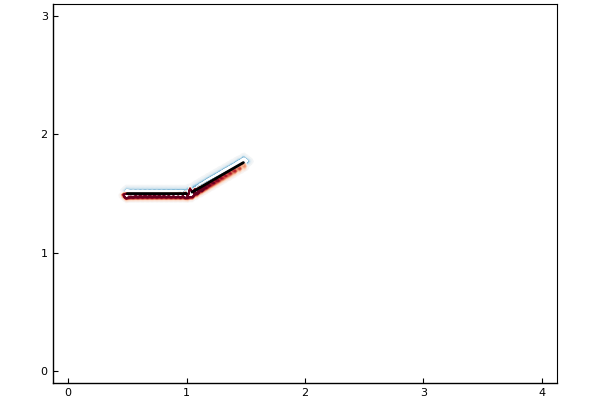

In [49]:
p = plot(xg,yg,whist[1],levels=contour_levels,color=:RdBu_r,clims=(-0.5,0.5))
for i = 1:bd.sys.nbody
    plot!(p,vshist[1][i,2:3,1], vshist[1][i,2:3,2],linewidth=2,linecolor="black")
end
p

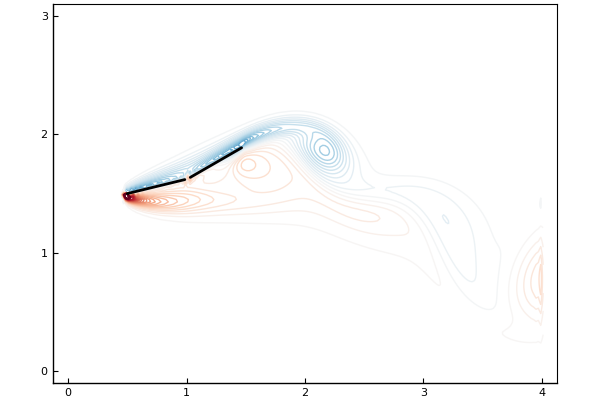

In [50]:
p = plot(xg,yg,whist[end],levels=contour_levels,color=:RdBu_r,clims=(-0.5,0.5))
for i = 1:bd.sys.nbody
    plot!(p,vshist[end][i,2:3,1], vshist[end][i,2:3,2],linewidth=2,linecolor="black")
end
# savefig(p,"plate.eps")
p

#### Body position begining and end

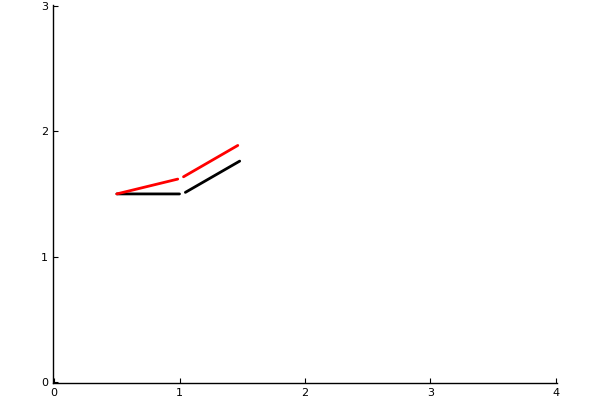

In [51]:
pb = plot()
for i = 1:sys.nbody
    plot!(pb,vshist[1][i,2:3,1], vshist[1][i,2:3,2],linewidth=2,linecolor="black",label="begin")
end
for i = 1:sys.nbody
    plot!(pb,vshist[end][i,2:3,1], vshist[end][i,2:3,2],linewidth=2,linecolor="red",label="end")
end
plot!(pb,xlims=(xg[1],xg[end]), ylims=(yg[1],yg[end]),ratio=1, legend=false)
pb

#### Make gif

In [33]:
# anim = @animate for j = 1:sample_rate:length(whist)
#     plot(xg,yg,whist[j],levels=contour_levels,color=:RdBu_r,clims=(-0.5,0.5))
#     for i = 1:sys.nbody
#         plot!(vshist[j][i,2:3,1], vshist[j][i,2:3,2],linewidth=2,linecolor="black")
#     end
# end

# gif(anim, filename*".gif", fps = fps)

#### Tail trajectory

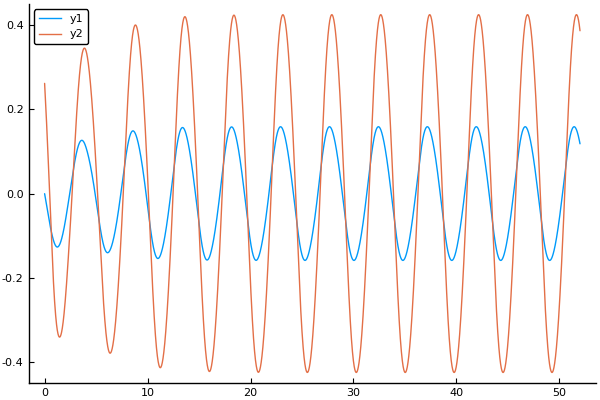

In [53]:
p1hist = []
p2hist = []

for i in 1:length(bdhist)
    push!(p1hist,bdhist[i].bs[1].verts_i[3,2]-1.5)    
    push!(p2hist,bdhist[i].bs[2].verts_i[3,2]-1.5)
end

plot(thist,p1hist)
plot!(thist,p2hist)

#### Deflection angle

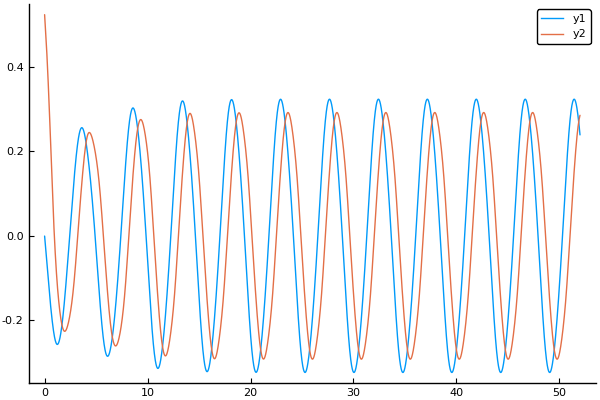

In [25]:
a1hist = []
a2hist = []

for i in 1:length(bdhist)
    push!(a1hist,bdhist[i].js[1].qJ[3])    
    push!(a2hist,bdhist[i].js[2].qJ[3])
end

plot(thist,a1hist)
plot!(thist,a2hist)

In [27]:
p2hist[100]

-0.7633152615300568

#### Force history

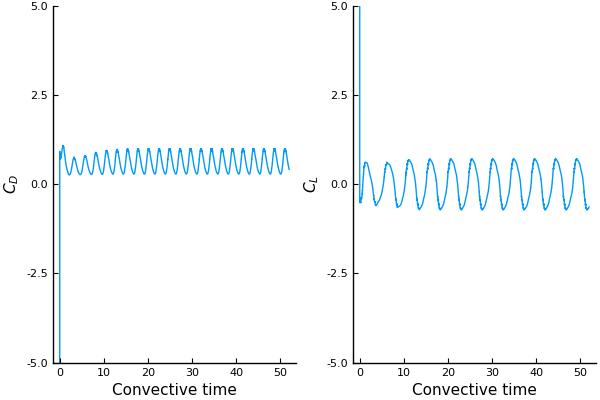

In [54]:
px = plot(thist,2*fx,ylim=(-5,5),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
py = plot(thist,2*fy,ylim=(-5,5),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot(px,py)

## <span style="color:blue"> Save Data </span>

#### Save all current data a .bson file

In [55]:
@save filename*".bson" bd bdhist xg yg whist vshist thist fx fy Δt w qJ v t f

#### Use the following block to extract data

In [ ]:
# using Dyn3d
# using ViscousFlow

# @load filename*".bson" bd bdhist xg yg whist vshist thist fx fy Δt w qJ v t f
# @get bd (bs,js,sys);